# Factor out the processing specifically for the plots

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install -e /home/jovyan/PROJECTS/scale-aware-air-sea --no-deps

In [3]:
import os
import numpy as np
import xarray as xr
from dask.distributed import Client
from scale_aware_air_sea.parameters import get_params
import matplotlib.pyplot as plt
from scale_aware_air_sea.stages import preprocess, construct_ice_mask
import gcsfs

In [4]:
params = get_params('v1.0.1', test=False)
models = params['paths'].keys()
open_kwargs = dict(
    engine='zarr',
    chunks={},
)
fs = gcsfs.GCSFileSystem(requester_pays=True)

In [5]:
# Reproducibility info
os.environ['JUPYTER_IMAGE']

'pangeo/pangeo-notebook:2023.08.29'

In [6]:
client = Client()
client

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43887 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jbusecke/proxy/43887/status,
Dashboard: /user/jbusecke/proxy/43887/status,Workers: 4
Total threads: 16,Total memory: 125.81 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36441,Workers: 4
Dashboard: /user/jbusecke/proxy/43887/status,Total threads: 16
Started: Just now,Total memory: 125.81 GiB
Comm: tcp://127.0.0.1:40217,Total threads: 4
Dashboard: /user/jbusecke/proxy/44665/status,Memory: 31.45 GiB
Nanny: tcp://127.0.0.1:42963,


In [7]:
def global_ave(ds:xr.Dataset) -> xr.Dataset:
    return ds.weighted(ds.area_t).mean(['xt_ocean', 'yt_ocean'])

### Indicate max extent of ice edge
We believe that our estimates within the are covered by ice in *any* part of the year are slightly biased (see XXX below). To give the reader an understanding of how much the values near the ice edge matter we construct a max extent ice edge mask and use this to indicate the potentially ice covered ares in any map plot, and also calculate alternative global means only for areas that remain ice free throughout the year.

In [8]:
max_ice_mask = {}
for model in models:
    ds_ice = xr.open_dataset(params['paths'][model]['fluxes']['filter']['prod'], **open_kwargs)
    max_ice_mask[model] = ~np.isnan(ds_ice.ql.sel(smoothing='smooth_none')).any('time').squeeze().load()

2024-01-30 00:19:26,905 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
2024-01-30 00:19:26,905 - distributed.nanny - ERROR - Worker process died unexpectedly
2024-01-30 00:19:26,905 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/nanny.py", line 1001, in _run
    asyncio_run(run(), loop_factory=get_loop_factory())
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/compatibility.py", line 236, in asyncio_run
    return loop.run_until_complete(main)
  File "/srv/conda/envs/notebook/lib/python3.10/asyncio/base_events.py", line 636, in run_until_complete
    self.run_forever()
  File "/srv/conda/envs/notebook/lib/python3.10/asyncio/base_events.py", line 603, in run

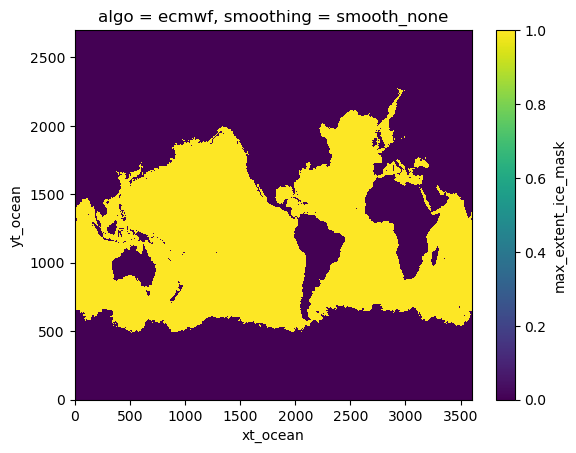

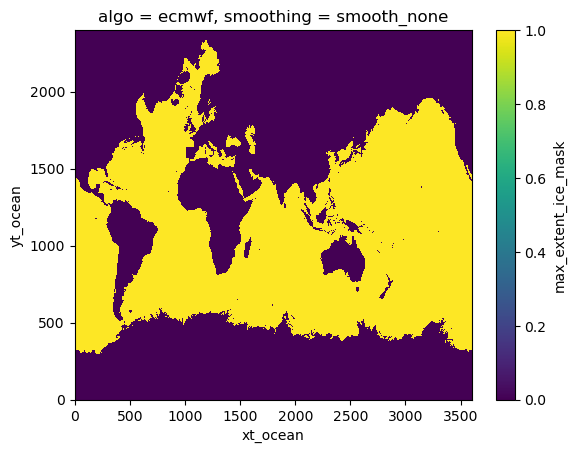

In [21]:
# save max_ice_mask to storage
for model, da in max_ice_mask.items():

    path = params['paths'][model]['plotting']['max_ice_mask']
    da.to_dataset(name='max_extent_ice_mask').to_zarr(
        path,
        consolidated=True,
        mode='w'
    )
    
    plt.figure()
    xr.open_dataset(path, **open_kwargs).max_extent_ice_mask.plot()

## Compute full flux timeseries and averages

In [28]:
cm26_offline_appendix = xr.open_dataset(params['paths']['CM26']['fluxes']['filter']['appendix'], **open_kwargs)
cm26_offline_prod = xr.open_dataset(params['paths']['CM26']['fluxes']['filter']['prod'], **open_kwargs)

cesm_offline_appendix = xr.open_dataset(params['paths']['CESM']['fluxes']['filter']['appendix'], **open_kwargs)
# CESM has the fluxes as daily output (and they are part of the atoms data
cesm_raw = preprocess(fs, 'CESM', include_fluxes=True)
cesm_fluxes = cesm_raw.where(cesm_raw.ice_mask)

# get the online fluxes for CM2.6 
# (this takes quite long... and produces a ton of warnings, 
# but I am reluctant to write this data out permanently)

# CM26 only has monthly flux output
# CESM has the fluxes as daily output (and they are part of the atoms data
cm26_raw = preprocess(fs, 'CM26')

# so we got to fit this manually
cm26_kwargs = dict(consolidated=True, use_cftime=True, engine="zarr")
ocean_boundary_path = "gs://cmip6/GFDL_CM2_6/control/ocean_boundary"
cm26_fluxes = xr.open_dataset(ocean_boundary_path, chunks={"time": 3}, **cm26_kwargs)
# create monthly ice mask 
cm26_monthly_max = cm26_raw.resample(time='1MS').max()
monthly_ice_mask = construct_ice_mask(cm26_monthly_max)
monthly_ice_mask = monthly_ice_mask.drop('time') # to avoid broadcasting issues
cm26_fluxes = cm26_fluxes.where(monthly_ice_mask)
# add area
cm26_fluxes = cm26_fluxes.assign_coords(area_t=cm26_raw.area_t)

CESM: Loading Data
Interpolating ocean velocities
Modify units
CESM: Align in time
CESM: Regridding atmosphere (this takes a while, because we are computing the weights on the fly)
CESM: Merging on ocean tracer grid
CESM: Calculate relative wind
CESM: Drop extra coords
CM26: Loading Data
Load Data
Interpolating ocean velocities
Modify units
CM26: Align in time
CM26: Regridding atmosphere (this takes a while, because we are computing the weights on the fly)
CM26: Merging on ocean tracer grid
CM26: Calculate relative wind
CM26: Drop extra coords


NameError: name 'construct_ice_mask' is not defined

In [58]:
full_fluxes = {}
full_fluxes['CM26-offline'] = cm26_offline_appendix[['ql', 'qh']].sel(smoothing='smooth_none')
# ‼️ CM26 online fluxes are only available monthly
full_fluxes['CM26-online'] = cm26_fluxes.isel(time=slice(0,12))[['evap_heat', 'sens_heat']].rename({'evap_heat':'ql', 'sens_heat':'qh'}) # only use the first year

full_fluxes['CESM-offline'] = cesm_offline_appendix[['ql', 'qh']].sel(smoothing='smooth_none')
# ‼️ CESM online fluxes have a different sign convention
full_fluxes['CESM-online'] = -cesm_fluxes.isel(time=slice(0,360))[['LHFLX','SHFLX']].rename({'LHFLX':'ql', 'SHFLX':'qh'}) # only use the first year

In [59]:
# Calculate the time means to save time
full_fluxes_time_mean = {k:ds.mean('time').load() for k,ds in full_fluxes.items()}

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 24.07 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [60]:
# Calculate the global average
full_fluxes_global_average = {k:global_ave(ds).load() for k,ds in full_fluxes.items()}

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 24.27 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [61]:
for model in models:
    for computed in ['online', 'offline']:
        for mean, d  in [('time_mean', full_fluxes_time_mean), ('global_mean', full_fluxes_global_average)]:
            ds = d[f"{model}-{computed}"]
            path = params['paths'][model]['plotting']['full_fluxes'][computed][mean]
            print(path)
            ds.to_zarr(path, consolidated=True, mode='w') 

gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.1/plotting/CM26_full_flux_online_time_mean.zarr
gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.1/plotting/CM26_full_flux_online_global_mean.zarr
gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.1/plotting/CM26_full_flux_offline_time_mean.zarr
gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.1/plotting/CM26_full_flux_offline_global_mean.zarr
gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.1/plotting/CESM_full_flux_online_time_mean.zarr
gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.1/plotting/CESM_full_flux_online_global_mean.zarr
gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.1/plotting/CESM_full_flux_offline_time_mean.zarr
gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.1/plotting/CESM_full_flux_offline_global_mean.zarr


## Compute small_scale fluxes averages

In [18]:
ds

<xarray.Dataset>
Dimensions:  (algo: 1, term: 4)
Coordinates:
  * algo     (algo) <U5 'ecmwf'
  * term     (term) <U17 'Q_H_bar' 'Q_star_star' ... 'Q_star_star_atmos'
Data variables:
    qh       (term, algo) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    ql       (term, algo) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    q_total  (term, algo) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>